In [1]:
import random
import numpy as np
import pandas as pd
import json
import cv2
import os
from functools import partial
from dataclasses import dataclass
from collections import OrderedDict
import torchvision
from IPython.display import clear_output
import matplotlib.pyplot as plt
import tqdm
import torch
from PIL import Image
from imutils.video import FileVideoStream
from pipeline.metrics import accuracy_b, log_loss
from pipeline.data_loaders import load_img_dataset, load_img_val_dataset
from pipeline.image_extracting import extract_faces, FastMTCNN

from pipeline.metrics import accuracy_sigmoid, accuracy_sigmoid_mean, log_loss_sigmoid, log_loss_b, accuracy_b_mean
from pipeline.image_extracting import crop_faces, FastMTCNN, InceptionResnetV1, extract_faces_dlib, MTCNN
from pipeline.blazeface import BlazeFace
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, Flip, OneOf, Compose, ImageCompression, Resize, RandomScale, RandomFog, RandomShadow, Downscale, JpegCompression, CenterCrop,
    RandomGamma, RandomContrast, Cutout, RandomCrop, Normalize, Cutout, RandomFog,Posterize,GaussianBlur
)
from albumentations.pytorch import ToTensor


random.seed(0)
np.random.seed(0)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

d:\users\user\appdata\local\programs\python\python36\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
d:\users\user\appdata\local\programs\python\python36\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
d:\users\user\appdata\local\programs\python\python36\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
class CV2VideoReader(object):
    
    def __init__(self, path, num_frames, stride=None, verbose=False):
        self.path = path
        self.num_frames = num_frames
        self.capture = None
        self.frame_count = None
        self.frame_counter = -1
        self.idx = 0
        self.stride = stride
        self.verbose = verbose

    def initialize(self):
        ret = False
        try:
            self.capture = cv2.VideoCapture(self.path)
            if self.capture.isOpened():
                self.frame_count = int(self.capture.get(cv2.CAP_PROP_FRAME_COUNT))
                if self.frame_count < self.num_frames:
                    self.num_frames = self.frame_count            
                if self.stride is None:
                    # Frames at regular interval
                    self.frame_idxs = np.linspace(0, self.frame_count, self.num_frames, endpoint=False, dtype=np.int)
                else:
                    # Frames with stride interval
                    self.frame_idxs = [i*self.stride for i in range(self.num_frames) if i*self.stride < self.frame_count]
                ret = True
        except Exception as ex:
            print("Init Error:", ex)              
        return ret

    def __len__(self):
        return len(self.frame_idxs)

    def __iter__(self):
        return self

    def __next__(self):
        decoded_frame = None
        decoded_frame_idx = None
        ret = None
        # Grab next frame until the selected one
        while ((self.frame_count is not None) and (self.idx < len(self.frame_idxs)) and (self.frame_counter < self.frame_count) and (self.frame_counter < self.frame_idxs[self.idx])):
            self.frame_counter = self.frame_counter + 1
            if self.verbose: print("grab", self.frame_counter)
            ret = self.capture.grab()
            if not ret:
                print("Error grabbing frame %d from %s" % (self.frame_counter, self.path))               
        # Retrieve the frame if possible
        if ret:
            if self.verbose: print("retrieve", self.frame_counter, self.frame_idxs[self.idx])
            ret, frame_tmp = self.capture.retrieve()
            if ret and frame_tmp is not None:
                decoded_frame = cv2.cvtColor(frame_tmp, cv2.COLOR_BGR2RGB)
                decoded_frame_idx = self.frame_counter
            else:
                print("Error retrieving frame %d from %s" % (self.frame_counter, self.path)) 
        # End of stream?
        if (self.frame_counter >= self.frame_count) | (self.idx >= len(self.frame_idxs)):
            self.release()
            raise StopIteration
        self.idx = self.idx + 1
        return (decoded_frame, decoded_frame_idx)

    def release(self):
        if self.capture is not None:
            self.capture.release()
            self.capture = None

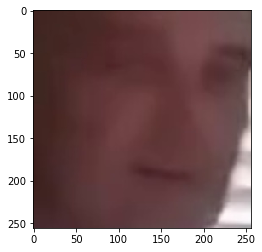

In [3]:
image = cv2.imread(r'C:\Users\user\Desktop\Projects\dfdc-kaggle-solution\data\train\fake\gigkljbtnw.0.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

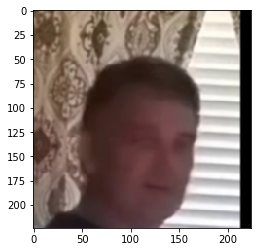

In [100]:
aug = RandomCrop(224,224)(image=image)['image']
#aug = JpegCompression(quality_lower=15, quality_upper=50, p=1)(image=aug)['image']
#aug = Downscale(scale_min=0.5, scale_max=0.9, p=1)(image=aug)['image']
aug = GaussianBlur(blur_limit=20,p=1)(image=aug)['image']
plt.imshow(aug)
plt.show()

In [3]:
facedet = BlazeFace().to(device)
facedet.load_weights("pipeline/blazeface.pth")
facedet.load_anchors("pipeline/anchors.npy")
_ = facedet.train(False)

from pipeline.helpers.read_video_1 import VideoReader
from pipeline.helpers.face_extract_1 import FaceExtractor

frames_per_video = 1

video_reader = VideoReader()
video_read_fn = lambda x: video_reader.read_frames(x, num_frames=frames_per_video)
face_extractor = FaceExtractor(video_read_fn, facedet)

In [4]:
y_train = pd.read_csv(r'data\metadata.csv')

In [31]:
y_train[y_train.label == 0].describe()

,label
count,19154.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [2]:
js = {}
for i in range(40, 50):
    with open(r'D:\Machine Learning\deepfake-detection\data\train_sets\dfdc_train_part_' + str(i) + '\metadata.json', 'r') as r:
        js.update(json.loads(r.read()))

In [3]:
val = js.keys()
out = r'D:\Machine Learning\deepfake-detection\data\all_vids'
inn = r'D:\Machine Learning\deepfake-detection\data\val'
for i in val:
    os.rename(out + '\\' + i, inn + '\\' + i)

In [2]:
path_val = r'data\img_val\fake'
path_fake = r'data\train\fake'
path_real = r'data\train\real'

val = [i for i in os.listdir(path_val)] 
fake = [i for i in os.listdir(path_fake)]
real = [i for i in os.listdir(path_real)]

In [3]:
fake_names = [i.split('.')[0] for i in fake]
real_names = [i.split('.')[0] for i in real]

for i in tqdm.tqdm_notebook(range(len(real))):
    filename = real[i]
    name, num, _ = filename.split('.')
    
    if real_names.count(name) > 1:
        os.rename(path_real + '\\' + filename, 'data\\least\\real\\' + filename)
        real_names[i] = None

d:\users\user\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [15]:
j = 0
for i in js:
    fname = i.split('.')[0]
    
    try:
        for file in fake:
            if fname in file:
                os.rename('data\\train\\fake\\' + file, 'data\\img_val_border\\fake\\' + file)
                j += 1
        for file in real:
            if fname in file:
                os.rename('data\\train\\real\\' + file, 'data\\img_val_border\\real\\' + file)
                j += 1
    except Exception as e:
        print(str(e))
print(j)

12121


In [10]:
removed = 0
for file in val:
    if file in fake:
        os.remove(path_fake + '\\' + file + '.jpg')
        removed += 1
        
    if file in real:
        os.remove(path_real + '\\' + file + '.jpg')
        removed += 1
        
print('Removed', removed)

Removed 0


In [3]:
from dsfd.detect import DSFDDetector, get_face_detections
weight_path = "dsfd/weights/WIDERFace_DSFD_RES152.pth"
detector = DSFDDetector(weight_path)

Finished loading model!


In [5]:
def isotropically_resize_image(img, size, resample=cv2.INTER_AREA):
    h, w = img.shape[:2]
    if w > h:
        h = h * size // w
        w = size
    else:
        w = w * size // h
        h = size

    resized = cv2.resize(img, (w, h), interpolation=resample)
    return resized


def make_square_image(img):
    h, w = img.shape[:2]
    size = max(h, w)
    t = 0
    b = size - h
    l = 0
    r = size - w
    return cv2.copyMakeBorder(img, t, b, l, r, cv2.BORDER_CONSTANT, value=0)

def detect_and_crop(video_path, detector, out_path, limit=1, delimeter=5):
    filename = video_path.split('\\')[-1].split('.')[0]
    vidcap = FileVideoStream(video_path).start()
    v_len = int(vidcap.stream.get(cv2.CAP_PROP_FRAME_COUNT))
    i = 0
    
    for j in range(v_len):
        if i >= limit:
            break

        if j % delimeter == 0:
            frame = vidcap.read()
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            faces = get_face_detections(detector, frame, .1).astype(int)
        
            if len(faces) == 0:
                print(filename, ' faces not found')
                continue

            for face in faces:
                xmin, ymin, xmax, ymax, prob = face
                face = cv2.resize(frame[ymin:ymax, xmin:xmax, :], (256, 256))
                face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
                cv2.imwrite(out_path + '.' + str(i) + '.jpg', face)
                i += 1

    vidcap.stop()

In [5]:
fast_mtcnn = FastMTCNN(
    stride=4,
    margin=14,
    factor=0.875,
    keep_all=False,
    device=device
)

In [8]:
def normalize(img):
    y, x, _ = img.shape
    
    if y > x and x < 256:
        ratio_x = x / y
        ratio_y = y / x

        return cv2.resize(img, (256, int(ratio_y * 256)))
    elif y < x and y < 256:
        ratio_x = x / y
        ratio_y = y / x

        return cv2.resize(img, (int(ratio_x * 256), 256))
    else:
        return cv2.resize(img, (256, 256))

In [ ]:
DATA_PATH = r'D:\Machine Learning\deepfake-detection\data\all_vids'
OUTPUT_PATH = r'D:\Machine Learning\deepfake-detection\data\frames'
files = os.listdir(DATA_PATH)


for i in tqdm.tqdm_notebook(range(len(files))):
    original_name = files[i].split('.')[0]
    y = y_train[y_train.name == original_name]
    fake = y.values[0][1]
        
    
    filename = DATA_PATH + '\\' + files[i]
    label = 'fake' if fake else 'real'

    try:
        reader_ = CV2VideoReader(filename, 5, stride=None)
        loaded_frames = []

        if reader_.initialize() == True:

            try:
                for frame, idx in reader_:
                    loaded_frames.append(frame)
            except Exception as ex:
                print("Cannot load:", ex)

        reader_.release()

        faces = fast_mtcnn(loaded_frames)

        del reader_, loaded_frames
        
        for i in range(len(faces)):
            try:
                frame_face = faces[i]
                resized_face = cv2.cvtColor(np.array(frame_face), cv2.COLOR_BGR2RGB)
                #resized_face = normalize(resized_face)
                resized_face = Resize(256, 256)(image=resized_face)['image']
                cv2.imwrite(OUTPUT_PATH + '\\' + label + '\\' + original_name + '.' + str(i) + '.jpg', resized_face)
            except Exception as e:
                print(str(e))
                    
    except Exception as e:
        print(str(e))

d:\users\user\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


OpenCV(4.2.0) C:\projects\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'

OpenCV(4.2.0) C:\projects\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'

OpenCV(4.2.0) C:\projects\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'

OpenCV(4.2.0) C:\projects\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'

OpenCV(4.2.0) C:\projects\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'

OpenCV(4.2.0) C:\projects\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'

OpenCV(4.2.0) C:\projects\opencv-python\opencv\modules\imgproc\src\col

In [35]:
face = np.array(faces[0])
resized_face = normalize(face)
face.shape, resized_face.shape

((239, 186, 3), (328, 256, 3))

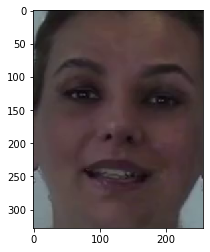

In [40]:
plt.imshow(resized_face)

In [13]:
y0 = torch.tensor([0]*2000 + [1]*2000)
y = torch.FloatTensor([0.1]*2400 + [0.9]*1600)
log_loss_b(y, y0), 0.6931

(0.3250797688961029, 0.6931)